# Experiments with Memory Access and Matrices

In many problems, especially problems accessing lots of data and doing relatively simple computations on each datum, the performance bottleneck is memory rather than computational speed.  Because memory is arranged into a **memory hierarchy** of larger/slower and smaller/faster memories, it turns out that *changing the order* of memory access can have a huge impact on performance.

In this notebook, we'll explore these performance issues with a few typical matrix algorithms, implemented in Julia.

In [19]:
using BenchmarkTools # a useful package of benchmarking utilities
versioninfo() # a useful function to print out information about the machine

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)
Environment:
  JULIA_EDITOR = code


## Benchmarking Matrix Multiplication

One of the most basic building blocks of numerical linear algebra is the computation of matrix multiplication: given an $m \times n$ matrix $A$ and an $n \times p$ matrix $B$, compute the $m \times p$ matrix $C = AB$.   The entries of $C$ are given by the exact formula:
$$
C_{ik} = \sum_{j=1}^n A_{ij} B_{jk}
$$
but there are many ways to implement this computation.   $\approx 2mnp$ flops (floating-point additions and multiplications) are required, but they can re-ordered arbitrarily, leading to $\sim (mnp)!$ possible orderings.

It turns out that the ordering of the operations in the matrix multiplication has a *huge* impact on performance, along with low-level details of the inner loops.  Basically, three factors make the implementation of efficient matrix multiplication highly nontrivial:

* [Caches](https://en.wikipedia.org/wiki/CPU_cache): the matrix accesses must be reordered to obtain [temporal locality](https://en.wikipedia.org/wiki/Locality_of_reference) and hence efficient memory (cache) usage.
* [Registers](https://en.wikipedia.org/wiki/Processor_register): at the lowest level, the CPU registers form a kind of ideal cache.  The innermost loops of the matrix multiplication need to be unrolled in order to load many values into registers and perform as much work with them as possible (essentially a small submatrix multiplication).  It turns out that a [lot of tricks](http://cscads.rice.edu/workshops/july2007/autotune-slides-07/Frigo.pdf) are required to do this well.
* [SIMD instructions](https://en.wikipedia.org/wiki/SIMD): modern CPUs include special instructions that can perform several arithmetic operations at once (e.g. 2, 4, or even 8 `Float64` operations), and to get the full benefit of these operations typically requires hand coding. 

As a consequence, there is a huge performance gap between the most obvious three-loop matrix-multiplication code and highly optimized code.  This gap has become the central factor in the design of dense linear-algebra libraries for several decades, especially the industry-standard free/open-source the [LAPACK](https://en.wikipedia.org/wiki/LAPACK) library: nearly all dense linear algebra is now organized around highly optimized [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) libraries.

Because Julia benefits from fast compilers, we can illustrate this performance gap fairly with simple Julia code.  (In contrast, similar implementation in Matlab or Python would be orders of magnitude slower, and would demonstrate mostly language rather than the algorithmic effects.)

### Naive algorithm

The following is the simplest, most obvious, matrix-multiplication algorithm: just three nested loops, implementing a dot product for each output $C_{ik}$.

The only concessions we have made to performance concerns here are (1) we implement an in-place `matmul!` variant that operates on a pre-existing `C` array, to avoid benchmarking the memory allocation/deallocation and (2) we use the `@inbounds` macro to turn off array bounds-checking in Julia for the inner loop.   Together, these make less than a factor of two difference in speed.

In [1]:
# compute C = A * B, using naive matrix-multiplication algorithm,
# with a pre-allocated output array C.  ("!" is a Julia convention
# for functions that modify their arguments.)
function matmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    for i = 1:m
        for k = 1:p
            c = zero(eltype(C))
            for j = 1:n
                @inbounds c += A[i,j] * B[j,k]
            end
            @inbounds C[i,k] = c
        end
    end
    return C
end

# a wrapper that allocates C of an appropriate type
matmul(A, B) = matmul!(Array{promote_type(eltype(A), eltype(B))}(undef,
                             size(A,1), size(B,2)),
                       A, B)

matmul (generic function with 1 method)

In [2]:
# correctness check:
A = rand(5,6)
B = rand(6,7)
using LinearAlgebra
norm(matmul(A,B) - A * B)

7.850462293418876e-16

#### Benchmarking naive `matmul`

Here, we will benchmark our naive `matmul` implementation against the highly optimized [OpenBLAS library](http://www.openblas.net/) that Julia uses for its built-in matrix multiplication.   Like `matmul!`, we will call OpenBLAS with pre-allocated output via `mul!(C, A, B)` instead of the simpler `A * B`.  By default, OpenBLAS uses multiple CPU cores, which gives it an "unfair" parallel speedup, but we can disable this for benchmarking purposes:

In [3]:
# for benchmarking, use only single-threaded BLAS:
BLAS.set_num_threads(1)

We will benchmark $n \times n$ matrix multiplications for various $n$ from 10 to 1000.  Julia's `@elapsed ...code...` macro is useful for benchmarking: it times the code and returns the time in seconds.   As we go, we will print the ratio of the naive time to the optimized time, to see the slowdown of our naive code.

In [4]:
N = round.(Int, 10 .^ range(1, log10(3000), length=60))  # 60 sizes from 10 to 3000
# alternatively, use N = 10:1000 to see some interesting patterns due to cache associativity etc.
t = Float64[]
t0 = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(t, @elapsed matmul!(C,A,B))
    push!(t0, @elapsed mul!(C,A,B))
    println("finished n = $n: slowdown of ", t[end]/t0[end])
end

finished n = 10: slowdown of 0.007835952511002333
finished n = 11: slowdown of 0.5407678244972578
finished n = 12: slowdown of 0.9910481163744872
finished n = 13: slowdown of 1.1469098277608916
finished n = 15: slowdown of 1.3363834422657952
finished n = 16: slowdown of 1.2491420727522307
finished n = 18: slowdown of 1.7147505422993494
finished n = 20: slowdown of 3.10800283286119
finished n = 22: slowdown of 2.6403125000000003
finished n = 24: slowdown of 0.4613533707628013
finished n = 26: slowdown of 3.140889591329871
finished n = 29: slowdown of 3.5693867375768655
finished n = 32: slowdown of 3.0392392392392393
finished n = 35: slowdown of 5.230943037222024
finished n = 39: slowdown of 5.4626268540202965
finished n = 43: slowdown of 3.833130637478463
finished n = 47: slowdown of 4.8330377147124715
finished n = 52: slowdown of 6.777450257921886
finished n = 57: slowdown of 5.776100659903477
finished n = 63: slowdown of 8.21405650778743
finished n = 69: slowdown of 7.740701381509033


In [5]:
using PyPlot # a plotting library based on Python's Matplotlib

Now, we will plot the results.  Since the number of flops is $2n^3$, we will plot $2n^3 / t$ for time $t$ in microseconds in order to plot the **gigaflops rate** (billions of flops per second).  If you naively think of a CPU as a box that performs floating-point instructions at a fixed rate, with all other instructions being negligible (a picture that *may* have been true circa 1985), this would be a flat horizontal line independent of $n$, but we will see that reality is quite different.

The OpenBLAS library gets an "unfair" factor of 8 speedup on typical modern Intel processors thanks to hand-coded support for [AVX-512](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions) SIMD instructions, which perform 8 double-precision floating-point operations simultaneously, so we will divide the BLAS performance by 8 for comparison purposes.

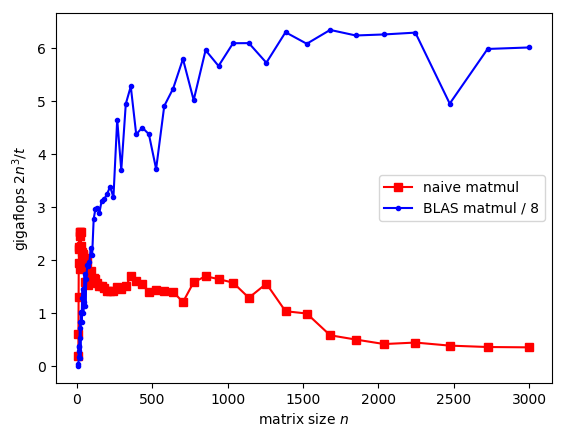

PyObject <matplotlib.legend.Legend object at 0x1464d7320>

In [6]:
plot(N, 2N.^3 ./ t * 1e-9, "rs-")
plot(N, 2N.^3 ./ t0 * 1e-9 / 8, "b.-")
ylabel(L"gigaflops $2n^3/t$")
xlabel(L"matrix size $n$")
legend(["naive matmul", "BLAS matmul / 8"], loc="center right")

#### Naive matmul in C

You may be suspicious that the problem is simply that Julia is slow.   We can check this hypothesis by implementing the same algorithm in C, compiling it, and then calling it by Julia's built-in `ccall` instruction that makes it [easy to call C from Julia](http://docs.julialang.org/en/latest/manual/calling-c-and-fortran-code/).

In [7]:
# C implementation:
Cmatmul = """
void Cmatmul(int m, int n, int p, double *C, double *A, double *B)
{
    int i, j, k;
    for (i = 0; i < m; ++i)
        for (j = 0; j < p; ++j) {
            double c = 0.0;
            for (k = 0; k < n; ++k)
                c += A[i + m*k] * B[k + n*j];
            C[i + m*j] = c;
    }
}
"""
# compile to a shared library by piping Cmatmul to gcc:
# (only works if you have gcc installed)
const Clib = tempname()
import Libdl
open(`gcc -fPIC -O3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, Cmatmul)
end

# define a Julia cmatmul! function that simply calls the C code in the shared library we compiled
function cmatmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    ccall(("Cmatmul", Clib), Cvoid, (Cint, Cint, Cint, Ptr{Float64}, Ptr{Float64}, Ptr{Float64}),
          m, n, p, C, A, B)
    return C
end
cmatmul(A, B) = cmatmul!(Array{promote_type(eltype(A), eltype(B))}(undef,
                               size(A,1), size(B,2)),
                         A, B)

cmatmul (generic function with 1 method)

In [8]:
# correctness check:
A = rand(5,6)
B = rand(6,7)
norm(cmatmul(A,B) - A * B)

8.15843973306311e-16

Now, let's benchmark it and print out the "speedup" compared to pure Julia.  We see that it is **about the same speed**.  Julia's main claim to fame is that it is a dynamic language (like Python or Matlab) that stays within a factor of 2 (usually better) of C.

In [9]:
tc = Float64[]
for n in N[N .<= 1000]
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(tc, @elapsed cmatmul!(C,A,B))
    println("finished n = $n: speedup of ", tc[end]/t[length(tc)])
end

finished n = 10: speedup of 1.4735042735042732
finished n = 11: speedup of 0.5609646157313499
finished n = 12: speedup of 0.44109898381633417
finished n = 13: speedup of 0.7146643109540637
finished n = 15: speedup of 0.8676230844473427
finished n = 16: speedup of 0.6898351648351649
finished n = 18: speedup of 0.7364537212734555
finished n = 20: speedup of 0.522501993847556
finished n = 22: speedup of 0.726003077287253
finished n = 24: speedup of 0.7255924604263886
finished n = 26: speedup of 0.7288476745021926
finished n = 29: speedup of 0.7832565069609349
finished n = 32: speedup of 0.7253145379092287
finished n = 35: speedup of 0.6866346875213131
finished n = 39: speedup of 0.7475929333166611
finished n = 43: speedup of 0.7434660180056317
finished n = 47: speedup of 0.710767507219223
finished n = 52: speedup of 0.7110652024210794
finished n = 57: speedup of 0.567258791281402
finished n = 63: speedup of 0.5850889145093108
finished n = 69: speedup of 0.7423596686006255
finished n = 76:

### Cache-oblivious matrix-multiplication

As a first step in the right direction, we'll implement a [cache-oblivious algorithm](https://en.wikipedia.org/wiki/Cache-oblivious_algorithm) for matrix multiplication: divide the matrices into four submatrices which are multiplied *recursively* until a sufficiently large base case is reached (large enough to amortize the recursion overhead).   This strategy erases the steep performance drop-off that occurs for large $n$ where the matrix goes out-of-cache, at the cost of ~25 lines of code rather than ~10 for the naive loops.

(It still doesn't match the OpenBLAS performance because it fails to address the other two problems: unrolling and optimizing the base cases to optimize register utilization, and coding for SIMD instructions.)

In [10]:
function add_matmul_rec!(m,n,p, i0,j0,k0, C,A,B)
    if m+n+p <= 64   # base case: naive matmult for sufficiently large matrices
        for i = 1:m
            for k = 1:p
                c = zero(eltype(C))
                for j = 1:n
                    @inbounds c += A[i0+i,j0+j] * B[j0+j,k0+k]
                end
                @inbounds C[i0+i,k0+k] += c
            end
        end
    else
        m2 = m ÷ 2; n2 = n ÷ 2; p2 = p ÷ 2
        add_matmul_rec!(m2, n2, p2, i0, j0, k0, C, A, B)
        
        add_matmul_rec!(m-m2, n2, p2, i0+m2, j0, k0, C, A, B)
        add_matmul_rec!(m2, n-n2, p2, i0, j0+n2, k0, C, A, B)
        add_matmul_rec!(m2, n2, p-p2, i0, j0, k0+p2, C, A, B)
        
        add_matmul_rec!(m-m2, n-n2, p2, i0+m2, j0+n2, k0, C, A, B)
        add_matmul_rec!(m2, n-n2, p-p2, i0, j0+n2, k0+p2, C, A, B)
        add_matmul_rec!(m-m2, n2, p-p2, i0+m2, j0, k0+p2, C, A, B)
        
        add_matmul_rec!(m-m2, n-n2, p-p2, i0+m2, j0+n2, k0+p2, C, A, B)
    end
    return C
end

function matmul_rec!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    fill!(C, 0)
    return add_matmul_rec!(m,n,p, 0,0,0, C,A,B)
end


matmul_rec(A, B) = matmul_rec!(Array{promote_type(eltype(A), eltype(B))}(undef,
                                     size(A,1), size(B,2)),
                               A, B)

matmul_rec (generic function with 1 method)

In [11]:
# correctness check:
A = rand(50,60)
B = rand(60,70)
norm(matmul_rec(A,B) - A * B)

2.0165366830864427e-13

In [12]:
tco = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(tco, @elapsed matmul_rec!(C,A,B))
    println("finished n = $n: slowdown of ", tco[end]/t0[length(tco)])
end

finished n = 10: slowdown of 3.472216971795036
finished n = 11: slowdown of 0.32224253503961
finished n = 12: slowdown of 0.6669153301007088
finished n = 13: slowdown of 1.1225937183383992
finished n = 15: slowdown of 1.3642701525054466
finished n = 16: slowdown of 1.2522306108442005
finished n = 18: slowdown of 1.8582791033984094
finished n = 20: slowdown of 2.5223087818696883
finished n = 22: slowdown of 3.0793749999999998
finished n = 24: slowdown of 0.516526657942505
finished n = 26: slowdown of 3.44321517272522
finished n = 29: slowdown of 3.426956955293335
finished n = 32: slowdown of 2.7860860860860863
finished n = 35: slowdown of 4.287430134379831
finished n = 39: slowdown of 4.838407494145199
finished n = 43: slowdown of 3.5849295631904328
finished n = 47: slowdown of 4.208551157580284
finished n = 52: slowdown of 5.854089904200442
finished n = 57: slowdown of 3.7928937259923177
finished n = 63: slowdown of 5.35827398189455
finished n = 69: slowdown of 6.34808021069168
finishe

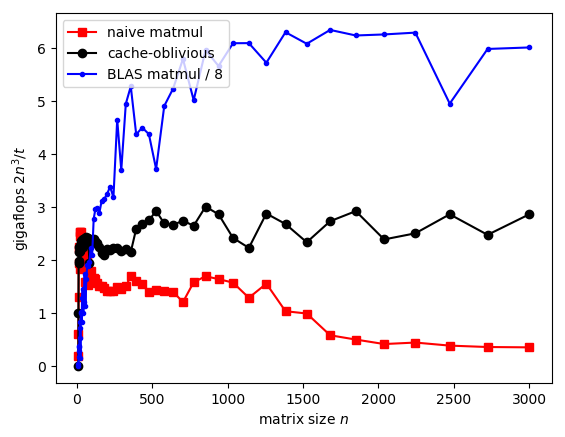

PyObject <matplotlib.legend.Legend object at 0x14909f6a0>

In [13]:
plot(N, 2N.^3 ./ t * 1e-9, "rs-")
plot(N, 2N.^3 ./ tco * 1e-9, "ko-")
plot(N, 2N.^3 ./ t0 * 1e-9 / 8, "b.-")
ylabel(L"gigaflops $2n^3/t$")
xlabel(L"matrix size $n$")
legend(["naive matmul", "cache-oblivious", "BLAS matmul / 8"], loc="upper left")

## Matrix addition

Matrix addition is an interesting case because it has no data re-use, so there is no possible temporal locality, but depending on *what order* you use for the loops and *how matrices are stored* in memory, you may or may not get **spatial locality** that takes advantage of **cache lines**.

Here let's implement matrix addition in two different ways.  As above, we'll use a pre-allocated output array so that our benchmark does not include the time for memory allocation:

In [14]:
function matadd1!(C, A, B)
    size(C) == size(A) == size(B) || throw(DimensionMismatchmatch())
    m,n = size(A)
    for i = 1:m
        @simd for j = 1:n
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end
matadd1(A, B) = matadd1!(similar(A, promote_type(eltype(A), eltype(B))), A, B)

function matadd2!(C, A, B)
    size(C) == size(A) == size(B) || throw(DimensionMismatch())
    m,n = size(A)
    for j = 1:n
        @simd for i = 1:m
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end
matadd2(A, B) = matadd2!(similar(A, promote_type(eltype(A), eltype(B))), A, B)

A = rand(5,6)
B = rand(5,6)
A + B ≈ matadd1(A,B) ≈ matadd2(A,B)

true

In [15]:
Na = round.(Int, 10 .^ range(1, log10(3000), length=60))  # 60 sizes from 10 to 3000
# alternatively, use N = 10:1000 to see some interesting patterns due to cache associativity etc.
t1 = Float64[]
t2 = Float64[]
for n in Na
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    matadd1!(C,A,B) # add once just to make sure we are in cache if A and B are small
    push!(t1, @elapsed matadd1!(C,A,B))
    push!(t2, @elapsed matadd2!(C,A,B))
    println("finished n = $n: ratio t1/t2 of ", t1[end]/t2[end])
end

finished n = 10: ratio t1/t2 of 0.15805825242718446
finished n = 11: ratio t1/t2 of 0.3351278600269179
finished n = 12: ratio t1/t2 of 0.6876712328767124
finished n = 13: ratio t1/t2 of 0.9090909090909092
finished n = 15: ratio t1/t2 of 1.1986301369863013
finished n = 16: ratio t1/t2 of 1.1702786377708978
finished n = 18: ratio t1/t2 of 1.0050632911392405
finished n = 20: ratio t1/t2 of 1.0904645476772616
finished n = 22: ratio t1/t2 of 1.0836909871244635
finished n = 24: ratio t1/t2 of 1.1186770428015564
finished n = 26: ratio t1/t2 of 1.1506129597197898
finished n = 29: ratio t1/t2 of 1.0486486486486486
finished n = 32: ratio t1/t2 of 1.9469387755102043
finished n = 35: ratio t1/t2 of 1.721875
finished n = 39: ratio t1/t2 of 1.8361581920903953
finished n = 43: ratio t1/t2 of 2.2688995215311003
finished n = 47: ratio t1/t2 of 2.0538585209003215
finished n = 52: ratio t1/t2 of 3.3249097472924185
finished n = 57: ratio t1/t2 of 2.8704896907216493
finished n = 63: ratio t1/t2 of 2.467078

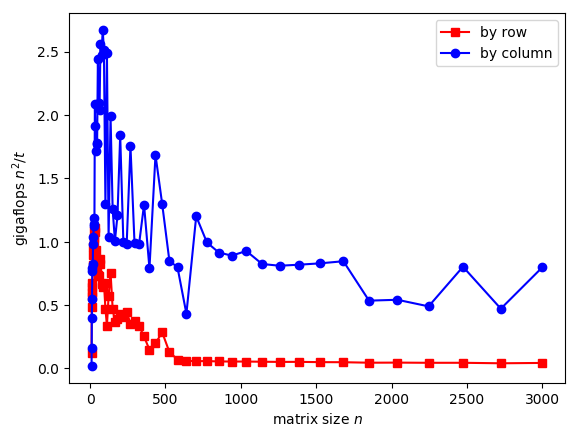

PyObject <matplotlib.legend.Legend object at 0x11fde3710>

In [16]:
plot(Na, Na.^2 ./ t1 * 1e-9, "rs-")
plot(Na, Na.^2 ./ t2 * 1e-9, "bo-")
xlabel(L"matrix size $n$")
ylabel(L"gigaflops $n^2/t$")
legend(["by row", "by column"])

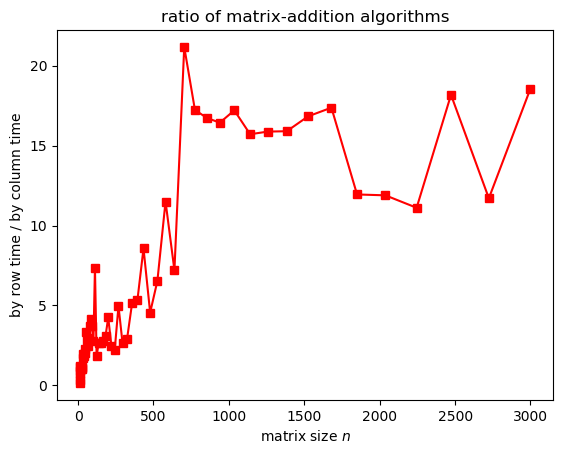

PyObject Text(0.5, 1.0, 'ratio of matrix-addition algorithms')

In [17]:
plot(Na, t1 ./ t2, "rs-")
xlabel(L"matrix size $n$")
ylabel("by row time / by column time")
title("ratio of matrix-addition algorithms")

We can see that addition is about ***20 times slower*** if we add by rows rather than by columns.

The reason for this is that **Julia stores matrices with consecutive columns**, which is known as **column-major storage** format.

## Other examples: vectorized vs. devectorized operations

Another example of the importance of spatial locality can be seen in vectorized operations.  For more information on this subject, see the blog post:

* [More Dots: Syntactic Loop Fusion in Julia](https://julialang.org/blog/2017/01/moredots)

Consider the following function, which computes $f(x) = 2x^2 - 3x + 4$ *element-wise* for an array of $x$ values:

In [23]:
f_vec(x) = 2 * x.^2 .- 3 * x .+ 4
f_devec(X) = f_vec.(X)

X = rand(10^6);

In [25]:
@btime f_vec($X);

  7.122 ms (9 allocations: 30.52 MiB)


In [26]:
@btime f_devec($X);

  1.310 ms (2 allocations: 7.63 MiB)


The `f_devec` function is about **5 times faster** than the vectorized version, and allocates about **1/4 the memory**.   That is because `f_vec` is effectively equivalent to:

In [27]:
function f_vec_really(x)
    tmp1 = x.^2
    tmp2 = 2 * tmp1
    tmp3 = 3 * x
    tmp4 = tmp2 .- tmp3
    tmp5 = tmp4 .+ 4
    return tmp5
end

f_vec_really (generic function with 1 method)

That is, each "vectorized" operation, like `x.^2`, while it is *individually fast*, does a *separate loop* over its data and *allocates a temporary array for the result*.  This is slow for three reasons:

* It has poor temporal locality.
* It is expensive to allocate all those temporary arrays.
* The overhead of looping (incrementing/testing a counter, fetching elements `x[i]`, etcetera), is incurred multiple times rather than once.

In Julia, there is a  syntax `2 .* x.^2 .- 3 .* x .+ 4`, or equivalently `@. 2x^2 - 3x + 4` in which the compiler is guaranteed to "fuse" the operations into a single loop, allocating no temporary arrays.